Inferring Recipes
---
University of Tübingen, Winter Term 2022/23
&copy; P. Hennig, 2022 CC BY-NC-SA 3.0


Have you ever wondered what goes into your (processed) food? Here is the back of a jar of "vegan liver paté":

<!-- <img src="Hedi_Leberwurst - 2.jpeg" style="height: 300px;"/> <img src="Hedi_Leberwurst - 3.jpeg" style="height: 300px;"/> -->
<img src="HediLeberwurst.png" style="height: 300px;"/>

In the EU, all contents of the product <a href="https://europa.eu/youreurope/business/product-requirements/food-labelling/general-rules/index_en.htm">have to be listed in descending order of their proportion by weight</a>. So if one ingredient ("Rapsöl") is listed before another on ("Röstzwiebeln"), this means there is more of the former ingredient in there then of the latter. So if $x\in\mathbb{R}^D$ is a vector of the proportions $0\leq x_i\leq 1$ of the $D$ ingredients, then the order of the ingredients printed on the back of the jar defines a **linear program** of the general form
\begin{align} 
Ax &\leq a \\
Bx &= b
\end{align}
(the $\leq$ is convention, $\geq$ inequalities can be realised as a line in $Ax = a$ by multiplying with $-1$), and thus a **likelihood** over the simplex of ingredient proportions
$$ p(A,a,B,b \mid x) = \begin{cases} 1 &\text{if $Ax\leq a$ and $Bx=b$} \\ 0 &\text{else}\end{cases} $$
Our goal this week will be to do Bayesian inference, using Markov Chain Monte Carlo, over this polytope to infer possible recipes for industrially produced food (from a *uniform* prior over the polytope).

Let's first get the mechanics out of the way by defining the linear program:

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from numpy.random import rand, randn
from tqdm import tqdm
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

8 ingredients in total


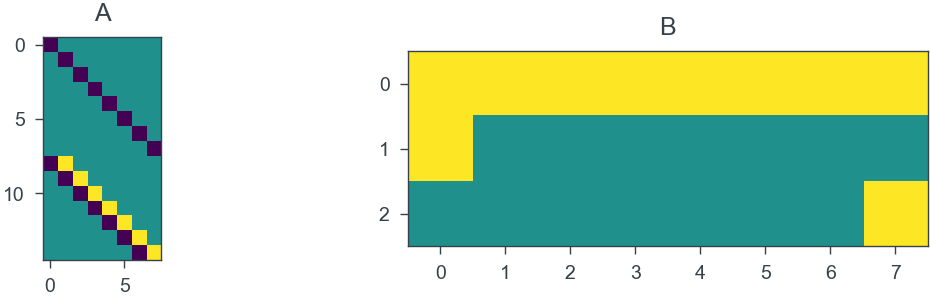

In [5]:
Zutaten = [
    "gek. Hülsenfrüchte (braune Berglinsen)",
    "Kokosfett",
    "Sonnenblumenöl",
    "geröstete Zwiebeln (in Sonnenblumenöl)",
    "Zitronensaft",
    "Gewürze",
    "Agavendicksaft",
    "geräuchertes Meersalz",
]

D = len(Zutaten)
print(f"{D} ingredients in total")

# WE NEED 2D - 1 INEQUALITIES:
# * all variables should be >0: (D inequality constraints)
# * the i-th variable is larger than the i+1-th variable, for all i in [1,D-1] (D-1 inequalities)
#
# AND 3 EQUALITIES:
# * all variables should sum to 1 (the D-simplex, 1 equality)
# * the first variable (gek. Linsen) is 0.63 (1 equality)
# * the 8th variable (Salz) is equal to 0.016 (1 equality)

# inequalities
A = np.zeros((D + D - 1, D))
a = np.zeros(D + D - 1)

# first, the >=0 inequality
A[0:D, 0:D] = -np.eye(D)  # note the minus, for the >= equality
a[0:D] = 0

# then the ordering:
for i in range(D - 1):
    A[D + i, i + 1] = 1
    A[D + i, i] = -1
    a[D + i] = 0

# equalities
B = np.zeros((3, D))
b = np.zeros(3)

# they all sum to 1:
B[0, :] = 1
b[0] = 1

# the first variable (Linsen) is 0.63:
B[1, 0] = 1
b[1] = 0.63

# * the 8th variable (Salz) is equal to 0.016 (1 equality)
B[2, 7] = 1
b[2] = 0.016

plt.rcParams.update(bundles.beamer_moml(rel_height=0.5))
# Set font because it uses a font which is not on every computer
plt.rcParams['font.family'] = 'Arial'
fig, axs = plt.subplots(1, 2)
imA = axs[0].imshow(A, vmin=-1, vmax=1)
axs[0].set_title("A")
imB = axs[1].imshow(B, vmin=-1, vmax=1)
axs[1].set_title("B")
# fig.colorbar(imA, ax=axs[1]);
plt.savefig("matrices.pdf")

#### The Algorithm:

We will implement a specially adapted version of **Slice Sampling** (invented by <a href="https://projecteuclid.org/journals/annals-of-statistics/volume-31/issue-3/Slice-sampling/10.1214/aos/1056562461.full">Radford Neal in 2003</a>). Before you continue, read <a href="https://en.wikipedia.org/wiki/Slice_sampling">the Wikipedia article on slice sampling</a>.

Slice sampling is an elegant adaptive MCMC algorithm that draws from $p(x)$ at a current Markov chain state $x_i$ by uniformly drawing along a univariate *slice* through $x$ of the width of $p(x)$ at (uniformly) randomly drawn height $[0,p(x_i)]$. Slice sampling is a general algorithm for densities $p(x)$. But our density is special: It is a uniform density over a linearly constrained polytope. In some ways this simplifies things and allows particularly efficient forms of slice sampling: Because our density is uniform over the polytope, we actually do not need to draw heights of the slices (because the resulting slices would be of the same width at all heights), and we will find below that we can compute the width of the slice analytically. Our setting also complicates things in one way: Because the density vanishes ($p(x)=0$) for $x$ outside of the polytope, we first need to find a point inside of the polytope before we start.

In short, our algorithm will thus look as follows:

1. Find a starting point $x_0$ *inside* of the polytope allowed by the likelihood.
2. while(True), do:
    1. draw a direction $s \in \mathbb{R}^D$ uniformly within the polytope (i.e. ensure that equality constraints are satisfied such that $x_i + \alpha s$ is inside of the polytope for all $\alpha\in(-1,1)$ and outside of it (or on its boundary) for all other $\alpha$.
    2. draw a new location $x_{i+1} = x_i + u s$ where $u$ is a uniform random variable in $(-1,1)$.

#### your first task: 

Make use of `scipy.optimize.linprog` to define a function `find_initial_point(A, a, B, b)` that finds a point $x_0$ *inside* of the polytope. 

As always when using a packaged numerical algorithm, it is a good idea to <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html">read the manual</a>. It will tell you that this wrapper provides access to highly optimized versions of the <a href="https://en.wikipedia.org/wiki/Simplex_algorithm">simplex algorithm</a> and <a href="https://en.wikipedia.org/wiki/Linear_programming#Interior_point">interior point methods</a>.

In [6]:
from scipy.optimize import linprog


def find_initial_point(A, a, B, b):
    D = A.shape[1]
    out = linprog(np.ones(D), A_ub=A, b_ub=a, A_eq=B, b_eq=b)
    return out.x

In [12]:
x0 = find_initial_point(A, a, B, b)

# check your implementation:
print(f"Test for inequalities: {np.all(A @ x0 - a < 0)}")
print(f"Test for equalities: {np.allclose(B @ x0 - b,0)}")

Test for inequalities: False
Test for equalities: True


#### your second task:

The trickiest part of our problem is to **find slice directions inside of the polytope**. Note that once we have a point $x_i$ that satisfies the inequality constraints (i.e. $Ax-a \leq 0$) then, for any $s \in \mathbb{R}^D$, there exists an $\epsilon>0$ such that $x_i+\epsilon s$ also satisfies these constraints. So the *in*equality constraints are actually not much of a problem. But the *equality* constraints $Bx-b=0# are. 

Define a function `construct_directions(B)` that *returns a function* `sample`, which itself returns a direction $s$ such that if $Bx-b=0$, then $B(x+\alpha u) = 0$ for all $\alpha$.

**Hint**: Note that this task is similar to Gaussian inference with vanishing measurement noise: For measurements $p(b\mid x) = \mathcal{N}(b;Bx,\sigma^2)$ under the prior $p(x)=\mathcal{N}(x;0,I)$, with noise variance $\sigma^2$, the posterior covariance would be
$$ \Sigma = I - B^T(BB^T + \sigma^2 I)^{-1} B$$
Unfortunately, simply implementing this matrix in the standard way (i.e. with Cholesky) won't work for $\sigma^2 \to 0$. 

However, we can use the SVD $B = QDU^T$ with $BB^T = QD^2 Q^T$ to write
$$ B^T (B B^T)^{-1} B = UDQ^T(Q D^{-2} Q^T) Q D U^T = UU^T. $$
So see if you can use `np.linalg.svd` to find a solution. Make sure to read about its `full_matrices` optional argument.

In [14]:
def construct_directions(B):
    """
    The main challenge here is to ensure the equality constraints remain satisfied
    Naïvely using random.multivariatenormal or similar typically adds a "nugget",
    a minimal amount of "noise" to the covariance's diagonal, which messes up the
    equality constaraints. We solve this by actually computing the SVD manually, and
    then setting all directions that have nearly zero singular values to an actual zero.
    """

    _, D = B.shape
    q, s, ut = np.linalg.svd(
        B, full_matrices=False
    )  # the "full_matrices=False" matters, otherwise the next line is garbage
    Q, S, Ut = np.linalg.svd(np.eye(D) - ut.T @ ut)
    S[S < 1e-12] = 0  # set numerically zero to actually zero
    Q[np.abs(Q) < 1e-12] = 0  # do the same for the directions
    R = Q[:, S != 0]  # only keep directions with nonzero singular value
    S = np.sqrt(S[S != 0])

    K = R.shape[1]

    # now define the sampling function, as per usual for multivariate Gaussians:
    def sample():
        u = R @ np.reshape(np.sqrt(S) * randn(K), [K, 1])
        u /= np.linalg.norm(u)
        return u.flatten()

    return sample

#### cutting the slice

once we have a point $x_i$ inside the polytope, and can draw directions $s$ from it that all allow nonzero steps within the polytope, we can define the following relatively simple algorithm to analytically find the two end points of the slice:

In [9]:
def project_and_sample(xi, s, A, a):
    # take direction d, project the inequality constraints Ax <= a onto it, and sample
    y = (A @ xi) - a  # value of inequality constraints
    z = A @ s  # projected onto the slice

    # find the *tightest* of all constraints in both directions (i.e. towards xi + d and xi - d).
    K = len(y)
    upper = np.inf
    lower = -np.inf
    for k in range(K):
        if z[k] > 0:
            upper = np.minimum(upper, -y[k] / z[k])
        elif z[k] < 0:
            lower = np.maximum(lower, -y[k] / z[k])

    # sanity checks:
    assert np.isfinite(lower) and np.isfinite(
        upper
    ), f"lower bound {lower} and upper bound {upper}"  # constraints exist
    assert ~np.isclose(upper, lower)  # slice has finite length

    # sample:
    a = lower + (upper - lower) * np.random.rand()

    return xi + a * s

#### putting it all together

if you have solved the above two tasks, you should be able to run the following code that implements the MCMC algorithm:

In [10]:
def MCMC(A, a, B, b, num_iter=int(1e7), thinning=int(1e5)):

    print("finding initial point.")
    out = linprog(np.ones(D), A_ub=A, b_ub=a, A_eq=B, b_eq=b)
    x0 = out.x.flatten()

    print("precomputing space of search directions")
    sample = construct_directions(B)

    print("starting MCMC loop")
    samples = np.zeros(shape=(num_iter, D))
    samples[0, :] = x0
    xi = x0
    for i in tqdm(range(num_iter - 1)):
        xi = project_and_sample(xi, sample(), A, a)
        samples[i + 1, :] = xi

    return samples[0::thinning, :]

In [11]:
S = int(1e5)
SAMPLES = MCMC(A, a, B, b, num_iter=S, thinning=int(S / 100))

finding initial point.
precomputing space of search directions
starting MCMC loop


  0%|          | 0/99999 [00:00<?, ?it/s]

AssertionError: 

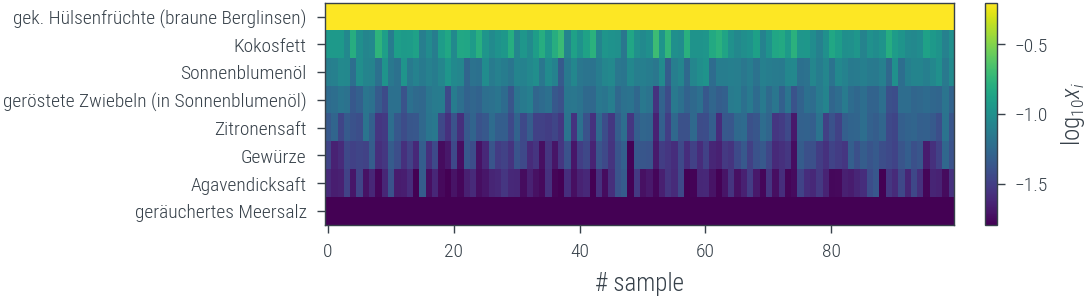

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.log10(SAMPLES.T), aspect="auto")
ax.set_xlabel("# sample")
# ax.set_ylabel('ingredient')
ax.set_yticks(np.arange(D))
ax.set_yticklabels(Zutaten)
cb = fig.colorbar(im)
cb.set_label("$\log_{10} x_i$")

# plt.savefig("Leberwurst_Samples.png")

A common way to diagnose MCMC convergence is by computing the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) of samples: We compute the means $\bar{x} = \frac{1}{N}\sum_n ^N x_n$ and then the autocorrelation
$$ [C(m)]_i = \frac{1}{N \bar{x}_i ^2}\sum_{n} (x_n - \bar{x})_i(x_{n-m} - \bar{x}_{n-m})_i  $$
If the Markov Chain is mixing well, we expect this function of $m$ to rapidly drop to 0, and to stochastically stay close to 0.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


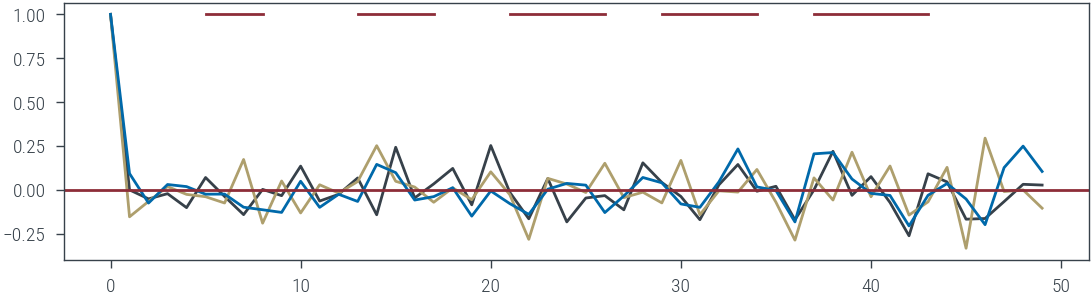

In [ ]:
def acf(x, length=50):
    return np.array([1] + [np.corrcoef(x[:-i], x[i:])[0, 1] for i in range(1, length)])


fig, ax = plt.subplots()
for i in range(4):
    ax.plot(acf(SAMPLES[:, i]))

ax.axhline(0);

In [ ]:
# SAMPLES = MCMC(A, a, B, b, num_iter=int(1e6), thinning=int(1e4))
mean_sample = np.mean(SAMPLES, axis=0)
std_sample = np.std(SAMPLES, axis=0)

print(f"MCMC predictions from {SAMPLES.shape[0]:d} (thinned) samples:")
print("=" * 56)
for i, zutat in enumerate(Zutaten):
    print(
        "{:>38}".format(zutat)
        + f": {mean_sample[i] * 100:5.2g}% +/- {2*std_sample[i] * 100:4.2f}%"
    )
print("=" * 56)

MCMC predictions from 100 (thinned) samples:
gek. Hülsenfrüchte (braune Berglinsen):    63% +/- 0.00%
                             Kokosfett:    12% +/- 5.60%
                        Sonnenblumenöl:   7.8% +/- 2.59%
geröstete Zwiebeln (in Sonnenblumenöl):   5.8% +/- 2.14%
                          Zitronensaft:   4.4% +/- 2.23%
                               Gewürze:   3.3% +/- 1.74%
                        Agavendicksaft:   2.4% +/- 1.37%
                 geräuchertes Meersalz:   1.6% +/- 0.00%


---

Here is the same Spiel for *Pastete*:
<img src="Pastete.png" style="height: 300px;"/>

In [ ]:
Zutaten = [
    "gek. Hülsenfrüchte (rote & braune Berglinsen)",
    "Kokosfett",
    "Sonnenblumenöl",
    "Gewüre (u.a. Senf)",
    "Zitronensaft",
    "geräuchertes Meersalz",
    "Agavendicksaft",
    "Shiitake",
]

D = len(Zutaten)
print(f"{D} ingredients in total")

# WE NEED 2D - 1 INEQUALITIES:
# * all variables should be >0: (D inequality constraints)
# * the i-th variable is larger than the i+1-th variable, for all i in [1,D-1] (D-1 inequalities)
#
# AND 4 EQUALITIES:
# * all variables should sum to 1 (the D-simplex, 1 equality)
# * the first variable (gek. Linsen) is 0.66 (1 equality)
# * the 2nd and third variables (Fat & Oils) together are equal to 0.25 (1 equality)
# * the 6th variable (salt) is 0.015

# inequalities
A = np.zeros((D + D - 1, D))
a = np.zeros(D + D - 1)

# first, the >=0 inequality
A[0:D, 0:D] = -np.eye(D)  # note the minus, for the >= equality
a[0:D] = 0

# then the ordering:
for i in range(D - 1):
    A[D + i, i + 1] = 1
    A[D + i, i] = -1
    a[D + i] = 0

# equalities
B = np.zeros((4, D))
b = np.zeros(4)

# they all sum to 1:
B[0, :] = 1
b[0] = 1

# the first variable (Linsen) is 0.66:
B[1, 0] = 1
b[1] = 0.66

# * the 2nd and third variables (Fat & Oils) together are equal to 0.25 (1 equality)
B[2, 1] = 1
B[2, 2] = 1
b[2] = 0.25

# * the 6th variable (salt) is 0.015
B[3, 5] = 1
b[3] = 0.015

8 ingredients in total


In [ ]:
S = int(1e5)
SAMPLES = MCMC(A, a, B, b, num_iter=S, thinning=int(S / 100))

mean_sample = np.mean(SAMPLES, axis=0)
std_sample = np.std(SAMPLES, axis=0)

print(f"MCMC predictions from {SAMPLES.shape[0]:d} (thinned) samples:")
print("=" * 66)
for i, zutat in enumerate(Zutaten):
    print(
        "{:>48}".format(zutat)
        + f": {mean_sample[i] * 100:5.2g}% +/- {2*std_sample[i] * 100:4.2f}%"
    )
print("=" * 66)

finding initial point.
precomputing space of search directions
starting MCMC loop


100%|██████████████████████████████████| 99999/99999 [00:03<00:00, 31604.70it/s]

MCMC predictions from 100 (thinned) samples:
   gek. Hülsenfrüchte (rote & braune Berglinsen):    66% +/- 0.00%
                                       Kokosfett:    17% +/- 5.32%
                                  Sonnenblumenöl:   8.2% +/- 5.32%
                              Gewüre (u.a. Senf):   3.8% +/- 1.28%
                                    Zitronensaft:   2.3% +/- 0.95%
                           geräuchertes Meersalz:   1.5% +/- 0.00%
                                  Agavendicksaft:  0.92% +/- 0.75%
                                        Shiitake:  0.48% +/- 0.69%


... and for Teewurst

<img src="HediTeewurst.png" style="height: 300px;"/>

In [ ]:
Zutaten = [
    "gek. Hülsenfrüchte (rote Linsen)",
    "Sonnenblumenöl",
    "Kokosfett",
    "Tomatenmark",
    "geräuchertes Meersalz",
    "Gewürze (u.a. Sellerie, Senf)",
    "Zitronensaft",
]

D = len(Zutaten)
print(f"{D} ingredients in total")

# WE NEED 2D - 1 INEQUALITIES:
# * all variables should be >0: (D inequality constraints)
# * the i-th variable is larger than the i+1-th variable, for all i in [1,D-1] (D-1 inequalities)
#
# AND 4 EQUALITIES:
# * all variables should sum to 1 (the D-simplex, 1 equality)
# * the first variable (gek. Linsen) is 0.55 (1 equality)
# * the 2nd and third variables (Fat & Oils) together are equal to 0.31 (1 equality)
# * the 5th variable (salt) is 0.02

# inequalities
A = np.zeros((D + D - 1, D))
a = np.zeros(D + D - 1)

# first, the >=0 inequality
A[0:D, 0:D] = -np.eye(D)  # note the minus, for the >= equality
a[0:D] = 0

# then the ordering:
for i in range(D - 1):
    A[D + i, i + 1] = 1
    A[D + i, i] = -1
    a[D + i] = 0

# equalities
B = np.zeros((4, D))
b = np.zeros(4)

# they all sum to 1:
B[0, :] = 1
b[0] = 1

# the first variable (Linsen) is 0.55:
B[1, 0] = 1
b[1] = 0.55

# * the 2nd and third variables (Fat & Oils) together are equal to 0.31 (1 equality)
B[2, 1] = 1
B[2, 2] = 1
b[2] = 0.31

# * the 5th variable (salt) is 0.015
B[3, 4] = 1
b[3] = 0.02

7 ingredients in total


In [ ]:
S = int(1e5)
SAMPLES = MCMC(A, a, B, b, num_iter=S, thinning=int(S / 100))

mean_sample = np.mean(SAMPLES, axis=0)
std_sample = np.std(SAMPLES, axis=0)

print(f"MCMC predictions from {SAMPLES.shape[0]:d} (thinned) samples:")
print("=" * 66)
for i, zutat in enumerate(Zutaten):
    print(
        "{:>48}".format(zutat)
        + f": {mean_sample[i] * 100:5.2g}% +/- {2*std_sample[i] * 100:4.2f}%"
    )
print("=" * 66)

finding initial point.
precomputing space of search directions
starting MCMC loop


100%|██████████████████████████████████| 99999/99999 [00:03<00:00, 32803.11it/s]

MCMC predictions from 100 (thinned) samples:
                gek. Hülsenfrüchte (rote Linsen):    55% +/- 0.00%
                                  Sonnenblumenöl:    18% +/- 3.38%
                                       Kokosfett:    13% +/- 3.38%
                                     Tomatenmark:   9.9% +/- 1.43%
                           geräuchertes Meersalz:     2% +/- 0.00%
                   Gewürze (u.a. Sellerie, Senf):   1.4% +/- 0.79%
                                    Zitronensaft:  0.71% +/- 0.88%


Und Cabanossi:

In [ ]:
Zutaten = [
    "gek. Hülsenfrüchte (rote Linsen)",
    "Kokosfett",
    "Sonnenblumenöl",
    "Gewürze (u.a. Sellerie, Senf)",
    "Tomatenmark",
    "geräuchertes Meersalz",
    "Zitronensaft",
    "Agavendicksaft",
    "Chili",
]

D = len(Zutaten)
print(f"{D} ingredients in total")

# WE NEED 2D - 1 INEQUALITIES:
# * all variables should be >0: (D inequality constraints)
# * the i-th variable is larger than the i+1-th variable, for all i in [1,D-1] (D-1 inequalities)
#
# AND 4 EQUALITIES:
# * all variables should sum to 1 (the D-simplex, 1 equality)
# * the first variable (gek. Linsen) is 0.61 (1 equality)
# * the 2nd and third variables (Fat & Oils) together are equal to 0.28 (1 equality)
# * the 6th variable (salt) is 0.021

# inequalities
A = np.zeros((D + D - 1, D))
a = np.zeros(D + D - 1)

# first, the >=0 inequality
A[0:D, 0:D] = -np.eye(D)  # note the minus, for the >= equality
a[0:D] = 0

# then the ordering:
for i in range(D - 1):
    A[D + i, i + 1] = 1
    A[D + i, i] = -1
    a[D + i] = 0

# equalities
B = np.zeros((4, D))
b = np.zeros(4)

# they all sum to 1:
B[0, :] = 1
b[0] = 1

# the first variable (Linsen) is 0.61:
B[1, 0] = 1
b[1] = 0.61

# * the 2nd and third variables (Fat & Oils) together are equal to 0.28 (1 equality)
B[2, 1] = 1
B[2, 2] = 1
b[2] = 0.28

# * the 6th variable (salt) is 0.015
B[3, 5] = 1
b[3] = 0.021

9 ingredients in total


In [ ]:
S = int(1e5)
SAMPLES = MCMC(A, a, B, b, num_iter=S, thinning=int(S / 100))

mean_sample = np.mean(SAMPLES, axis=0)
std_sample = np.std(SAMPLES, axis=0)

print(f"MCMC predictions from {SAMPLES.shape[0]:d} (thinned) samples:")
print("=" * 66)
for i, zutat in enumerate(Zutaten):
    print(
        "{:>48}".format(zutat)
        + f": {mean_sample[i] * 100:5.2g}% +/- {2*std_sample[i] * 100:4.2f}%"
    )
print("=" * 66)

finding initial point.
precomputing space of search directions
starting MCMC loop


100%|██████████████████████████████████| 99999/99999 [00:03<00:00, 31450.72it/s]

MCMC predictions from 100 (thinned) samples:
                gek. Hülsenfrüchte (rote Linsen):    61% +/- 0.00%
                                       Kokosfett:    19% +/- 5.93%
                                  Sonnenblumenöl:   8.7% +/- 5.93%
                   Gewürze (u.a. Sellerie, Senf):   3.7% +/- 1.44%
                                     Tomatenmark:   2.7% +/- 0.82%
                           geräuchertes Meersalz:   2.1% +/- 0.00%
                                    Zitronensaft:   1.4% +/- 0.89%
                                  Agavendicksaft:  0.76% +/- 0.75%
                                           Chili:  0.31% +/- 0.53%


Und Currywurst:

In [ ]:
Zutaten = [
    "gek. Hülsenfrüchte (rote Linsen)",
    "Kokosfett",
    "passierte Tomaten",
    "Sonnenblumenöl",
    "Agavendicksaft",
    "Tomatenmark",
    "Gewürze (Curry!)",
    "geräuchertes Meersalz",
    "geröstete Zwiebeln",
    "Zitronensaft",
    "Shiitake",
]

D = len(Zutaten)
print(f"{D} ingredients in total")

# WE NEED 2D - 1 INEQUALITIES:
# * all variables should be >0: (D inequality constraints)
# * the i-th variable is larger than the i+1-th variable, for all i in [1,D-1] (D-1 inequalities)
#
# AND 4 EQUALITIES:
# * all variables should sum to 1 (the D-simplex, 1 equality)
# * the first variable (gek. Linsen) is 0.50 (1 equality)
# * the 3nd and 4th variables (Fat & Oils) together are equal to 0.21 (1 equality)
# * the 8th variable (salt) is 0.021

# inequalities
A = np.zeros((D + D - 1, D))
a = np.zeros(D + D - 1)

# first, the >=0 inequality
A[0:D, 0:D] = -np.eye(D)  # note the minus, for the >= equality
a[0:D] = 0

# then the ordering:
for i in range(D - 1):
    A[D + i, i + 1] = 1
    A[D + i, i] = -1
    a[D + i] = 0

# equalities
B = np.zeros((4, D))
b = np.zeros(4)

# they all sum to 1:
B[0, :] = 1
b[0] = 1

# the first variable (Linsen) is 0.50:
B[1, 0] = 1
b[1] = 0.50

# * the 3nd and fourth variables (Fat & Oils) together are equal to 0.21 (1 equality)
B[2, 1] = 1
B[2, 2] = 1
b[2] = 0.21

# * the 8th variable (salt) is 0.021
B[3, 7] = 1
b[3] = 0.021

11 ingredients in total


In [ ]:
S = int(1e5)
SAMPLES = MCMC(A, a, B, b, num_iter=S, thinning=int(S / 100))

mean_sample = np.mean(SAMPLES, axis=0)
std_sample = np.std(SAMPLES, axis=0)

print(f"MCMC predictions from {SAMPLES.shape[0]:d} (thinned) samples:")
print("=" * 66)
for i, zutat in enumerate(Zutaten):
    print(
        "{:>48}".format(zutat)
        + f": {mean_sample[i] * 100:5.2g}% +/- {2*std_sample[i] * 100:4.2f}%"
    )
print("=" * 66)

finding initial point.
precomputing space of search directions
starting MCMC loop


100%|██████████████████████████████████| 99999/99999 [00:03<00:00, 28916.85it/s]

MCMC predictions from 100 (thinned) samples:
                gek. Hülsenfrüchte (rote Linsen):    50% +/- 0.00%
                                       Kokosfett:    12% +/- 1.67%
                               passierte Tomaten:   9.4% +/- 1.67%
                                  Sonnenblumenöl:   8.3% +/- 1.91%
                                  Agavendicksaft:   6.9% +/- 1.62%
                                     Tomatenmark:   5.2% +/- 1.85%
                                Gewürze (Curry!):   3.5% +/- 1.70%
                           geräuchertes Meersalz:   2.1% +/- 0.00%
                              geröstete Zwiebeln:   1.5% +/- 0.78%
                                    Zitronensaft:     1% +/- 0.90%
                                        Shiitake:  0.53% +/- 0.81%
